# Airline Analysis

Resources:

Economics:
http://www.oecd.org/daf/competition/airlinecompetition.htm

Graph theoretical:
https://beta.vu.nl/nl/Images/werkstuk-meer_tcm235-280356.pdf

aircraft traffic data by main airport:
https://datamarket.com/data/set/196g/aircraft-traffic-data-by-main-airport#!ds=196g!nto=6:ntp=b:ntq=3:ntr=1.1g.1u.7.z.a.j.v.1b.t.d.s.1n.12.p.8.b.y.e.19.17.1v.9.i.11.1f.1s.1a.1w.x.14.1l.1p.4.k.1r.g.1x.1c.f.15.q.1j.1t.l.1k.1h:nts=nf.rb&display=line





In [1]:
import  geopy
from  geopy.distance import distance #calculates distance based on coordinates
from geopy.geocoders import Nominatim

import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import urllib3
from bs4 import BeautifulSoup
urllib3.disable_warnings()
from urllib.parse import quote

import unicodedata
import string
import re

## Data processing

### Loading the dataset

Pull up-to-date data from github

In [2]:
!bash download_data.sh

Getting airports data
Getting airlines data
Getting routes data
Getting planes data


In [3]:
airports = pd.read_csv('airports.dat', header=None, names=
                      ["AirportID","Name", "City", "Country", "IATA", "ICAO",
                       "Latitude", "Longitude", "Altitude", "Timezone", "DST", "TzDatabaseTimeZone",
                       "Type", "Source"],
                      na_values='\\N')
airlines = pd.read_csv('airlines.dat', header=None, names=
                       ["AirlineID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"]
                       ,na_values='\\N')
routes = pd.read_csv('routes.dat', header=None, names=
                     ['Airline', 'AirlineID', 'SourceAirport', 'SourceAirportID', 'DestinationAirport',
                      'DestinationAirportID', 'Codeshare', 'Stops', 'Equipment'],
                    na_values='\\N')
planes = pd.read_csv('planes.dat', header=None, names=['Name', 'IATA code', 'ICAO code'])

In [4]:
routes.head()

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,2B,410.0,AER,2965.0,KZN,2990.0,NaN,0,CR2
1,2B,410.0,ASF,2966.0,KZN,2990.0,NaN,0,CR2
2,2B,410.0,ASF,2966.0,MRV,2962.0,NaN,0,CR2
3,2B,410.0,CEK,2968.0,KZN,2990.0,NaN,0,CR2
4,2B,410.0,CEK,2968.0,OVB,4078.0,NaN,0,CR2


In [5]:
airlines.head()

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,NaN,-,NaN,NaN,NaN,Y
1,1,Private flight,NaN,-,NaN,NaN,NaN,Y
2,2,135 Airways,NaN,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,NaN,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,NaN,NaN,WYT,NaN,United Kingdom,N


Only keep airports in that are both in routes dataframe:

In [6]:
valid_airports = set(routes.SourceAirport).union(set(routes.DestinationAirport)) 
airports = airports[airports.IATA.isin(valid_airports)]

Only keep airlines in intersection of that are both in the airline and in the routes dataframe :

In [7]:
valid_airlines = set(routes.AirlineID)

In [8]:
airlines = airlines[airlines.AirlineID.isin(valid_airlines)]
routes = routes[routes.AirlineID.isin(valid_airlines)]

We check that for each airline we have exactly one edge between a given source and destination none. This means that our graph will be unweighted. 

In [9]:
routes_by_airline = routes[['SourceAirport', 'DestinationAirport', 'Airline']]
routes_by_airline.drop_duplicates().shape == routes_by_airline.shape

True

Only take direct flights, only very few have more than that anyway

In [10]:
routes = routes[routes.Stops == 0]

### Adding Missing Airports

Airports to fill in information for :

In [11]:
len(valid_airports - set(airports.IATA))

204

Web crawling:

In [21]:
all_data = []
to_find = valid_airports - set(airports.IATA)

for u in string.ascii_uppercase:
    url =u'https://en.wikipedia.org/wiki/List_of_airports_by_IATA_code:_'+quote(u)
    http_pool = urllib3.connection_from_url(url)
    r = http_pool.urlopen('GET',url)

    html = r.data

    tree = BeautifulSoup(html,"lxml")
    table_tag = tree.select("table")[0]
    tab_data = [[item.text.replace('\n', '') for item in row_data.select("th,td")]
                    for row_data in table_tag.select("tr")]
    all_data = all_data + tab_data

df = pd.DataFrame(all_data[2:], columns=all_data[0])
df = df[df.IATA.isin(to_find)]

In [22]:
df.count()

IATA               176
ICAO               176
Airport name       176
Location served    176
Time               105
DST                105
dtype: int64

In [23]:
geolocator = Nominatim(timeout=3, user_agent="my-application")

In [24]:
def get_info(address):
    try:
        location = geolocator.geocode(address, addressdetails=True, language='en')
        return location.raw['address']['country'], location.raw['lon'], location.raw['lat']
    except:
        return None, None, None

Cleaning the dataframe:

In [25]:
details = df['Location\xa0served'].map(lambda x: get_info(x))

df['Country'] = details.map(lambda x: x[0])
df['Longitude'] = details.map(lambda x: x[1])
df['Latitude'] = details.map(lambda x: x[2])

df['Airport\xa0name'] = df['Airport\xa0name'].map(lambda x: re.sub('[\d\[\]]*|\([A-Z\ \:\d]*\)', '', x).strip())
df.rename(columns={'Airport\xa0name': 'Name', 'Location\xa0served': 'City'}, inplace=True)

df['Country'] = df.City.map(lambda x: x.split(',')[-1])
df['City'] = df.City.map(lambda x: x.split(',')[0])

del df['DST']

Manual additions to the dataset:

In [26]:
newMatrix = [['Altay Air Base', 'AAT', 47.7498856, 88.0858078, 'Altay', 'China', 'ZWAT'],
             ['Baise Youjiang Airport ', 'AEB', 23.7206001, 106.9599991, 'Baise', 'China', 'ZGBS'],
             ['Tasiilaq', 'AGM', 65.6122961, -37.6183355, 'Tasiilaq', 'Greenland', 'BGAM'],
             ['Atmautluak Airport', 'ATT', 60.8666992, -162.272995, 'Atmautluak', 'United States', ''],
             ['Branson Airport', 'BKG', 36.532082, -93.200544, 'Branson', 'United States', 'KBBG'],
             ['Baoshan Yunduan Airport', 'BSD', 25.0533009, 99.1682968, 'Baoshan', 'United States', 'ZPBS'],
             ['Laguindingan Airport', 'CGY', 8.612203, 124.456496, 'Cagayan de Oro City', 'Philippines', ''],
             ['Chuathbaluk Airport', 'CHU', 61.579102, -159.216003, 'Chuathbaluk', 'United States', 'PACH'],
             ['Crooked Creek Airport', 'CKD', 61.8679008, -158.1349945, 'Crooked Creek', 'United States', 'CJX'],
             ['Desierto De Atacama Airport', 'CPO', -27.2612, -70.7791977, 'Copiapo', 'Chile', 'SCAT'],
             ['Dandong Airport', 'DDG', 40.0247002, 124.2860031, 'Dandong', 'China', 'ZYDD'],
             ['Hamad International Airport', 'DOH', 25.2620449, 51.6130829, 'Doha', 'Qatar', 'OTHH'],
             ['Dongying Shengli Airport', 'DOY', 37.5085983, 118.788002, 'Dongying', 'China', 'ZSDY'],
             ['Saertu Airport', 'DQA', 46.7463889, 125.1405556, 'Daqing Shi', 'China', 'ZYDQ'],
             ['Førde Airport', 'FDE', 61.3911018, 5.7569399, 'Førde', 'Norway', 'ENBL'],
             ['FMt. Fuji Shizuoka Airport', 'FSZ', 34.7960435, 138.1877518, 'Makinohara', 'Japan', 'RJNS'],
             ['Foshan Shadi Airport', 'FUO', 23.0832996, 113.0699997, 'Foshan', 'China', 'ZGFS'],
             ['Goulimime Airport', 'GLN', 29.0266991, -10.0502996, 'Goulimime', 'Morocco', 'GMAG'],
             ['Gheshm Airport', 'GSM', 26.9487, 56.2687988, 'Gheshm', 'Iran', 'OIKQ'],
             ['Lianshui Airport', 'HIA', 33.7908333, 119.125, 'Huai\'an', 'China', 'ZSSH'],
             ['Iğdır Airport', 'IGD', 39.9766274, 43.876648, 'Iğdır', 'Turkey', 'LTCT'],            
             ['Kingman Airport', 'IGM', 35.2594986, -113.9380035, 'Kingman', 'United States', 'KIGM'],
             ['Jiagedaqi Airport', 'JGD', 50.375, 124.1166667, 'Jiagedaqi', 'China', ''],
             ['Jinggangshan Airport', 'JGS', 26.8568993, 114.7369995, 'Ji\'an', 'China', 'ZSJA'],
             ['Jinchuan Airport', 'JIC', 38.5422222, 102.3483333, 'Jinchang', 'China', 'ZLJC'],
             ['Qianjiang Wulingshan Airport', 'JIQ', 29.5133333, 108.8311111, 'Qianjiang', 'China', 'ZUQJ'],            
             ['Chizhou Jiuhuashan Airport', 'JUH', 30.7403, 117.6856, 'Chizhou', 'China', 'ZSJH'],
             ['Stagen Airport', 'KBU', -3.2947199, 116.1650009, 'Laut Island', 'Indonesia', 'WAOK'],
             ['Grayling Airport', 'KGX', 62.8945999, -160.0650024, 'Grayling', 'United States', 'PAGX'],
             ['Akiachak Airport', 'KKI', 60.9079018, -161.4349976, 'Akiachak', 'United States', 'KKI'],
             ['Kulusuk Airport', 'KUS', 65.5736008, -37.1236, 'Kulusuk', 'Greenland', 'BGKK'],
             ['Long Banga Airport', 'LBP', 3.202, 115.4018, 'Long Banga', 'Malaysia', ''],
             ['Lintsang Airfield', 'LNJ', 23.7381001, 100.0250015, 'Lincang', 'China', 'ZPLC'],
             ['Lublin Airport', 'LUZ', 51.240278, 22.713611, 'Lublin', 'Poland', 'EPLB'],
             ['Tampa Padang Airport', 'MJU', -2.583333, 119.033333, 'Mamuju-Celebes Island', 'Indonesia', 'WAWJ'],
             ['Basel Mulhouse Freiburg Airport', 'MLH',  47.5999, 7.53166, 'Basel Mulhouse Freiburg', 'France', 'LFSB'],
             ['Misratah Airport', 'MRA',  32.3250008, 15.0609999, 'Misratah', 'Libya', 'HLMS'],
             ['Enfidha - Hammamet International Airport', 'NBE',  36.075833, 10.438611, 'Enfidha', 'Tunisia', 'DTNH'],
             ['Changbaishan Airport', 'NBS',  42.0669444, 127.6022222, 'Baishan', 'China', 'ZYBS'],
             ['Nuussuaq Heliport', 'NSQ',  74.109722, -57.065, 'Nuussuaq', 'Greenland', 'BGNU'],
             ['Niaqornat Heliport', 'NIQ',  70.788889, -53.656111, 'Niaqornat', 'Greenland', 'BGNT'],
             ['Nantong Airport', 'NTG',  32.0708008, 120.9759979, 'Nantong', 'China', 'ZSNT'],
             ['Nunapitchuk Airport', 'NUP',  60.9057999, -162.4389954, 'Nunapitchuk', 'United States', 'PPIT'],
             ['Point Hope Airport', 'PHO', 68.3488007 , -166.798996, 'Point Hope', 'United States', 'PAPO'],
             ['Pilot Station Airport', 'PQS', 61.9346008 , -162.8999939, 'Pilot Station', 'United States', ''],
             ['Pomala Airport', 'PUM', -4.1810899 , 121.6179962, 'Kolaka', 'Indonesia', 'WAWP'],
             ['Bao\'anying Airport', 'PZI', 26.54 , 101.79852, 'Panzhihua', 'China', 'ZUZH'],
             ['Narsaq Kujalleq', 'QFN', 60.0046935, -44.6569347, 'Narsaq Kujalleq', 'Greenland', 'BGFD'],
             ['Igaliku', 'QFX', 60.9920065, -45.4323345, 'Igaliku', 'Greenland', 'BGIO'],
             ['Qassimiut Heliport', 'QJH', 60.779444,  -47.1525, 'Qassimiut', 'Greenland', 'BGQT'],
             ['Aappilattoq', 'QUV', 60.1483571,  -44.2869186, 'Nanortalik', 'Greenland', 'BGAQ'],
             ['Ammassivik', 'QUW', 60.5973758,  -45.3824455, 'Ammassivik', 'Greenland', 'BGAS'],
             ['Red Devil Airport', 'RDV', 61.7881012,  -157.3500061, 'Red Devil', 'United States', 'RDV'],
             ['Rio Grande Airport', 'RIG', -32.081699,  -52.163299, 'Rio Grande', 'Brazil', 'SJRG'],
             ['Saattut Heliport', 'SAE', 70.808611,  -51.626667, 'Saattut', 'Greenland', 'BGST'],
             ['Shire Inda Selassie Airport', 'SHC', 14.0781002,  38.2724991, 'Shire Indasilase', 'Ethiopia', ''],
             ['Stony River 2 Airport', 'SRV', 61.7896996,  -156.5890045, 'Stony River', 'United States', 'SRV'],
             ['Sheldon Point Airport', 'SXP', 62.5205994,  -164.8480072, 'Nunam Iqua', 'United States', 'SXP'],
             ['Semera Airport', 'SZE', 11.7875,  40.9915, 'Semera', 'Ethiopia', 'HASM'],
             ['Tuticorin Airport', 'TCR', 8.7241667,  78.0258333, 'Thoothukudi', 'India', 'VOTK'],
             ['Tanjung Manis Airport', 'TGC', 2.17784,  111.2020035, 'Tanjung Manis', 'Malaysia', 'WBGT'],
             ['Thọ Xuân Airport', 'THD', 19.901667,  105.467778, 'Sao Vàng', 'Vietnam', 'VVTX'],
             ['Tuluksak Airport', 'TLT', 61.0877292,  -160.9233542, 'Tuluksak', 'United States', 'TLT'],
             ['Tununak Airport', 'TNK', 60.5755005,  -165.2720032, 'Tununak', 'United States', '4KA'],
             ['Tasiusaq Heliport', 'TQA', 73.373055,  -56.06028, 'Tasiusaq', 'Greenland', 'BGTA'],
             ['Tangshan Sannühe Airport', 'TVS', 39.7178001,  118.0026245, 'Tangshan', 'China', 'ZBTS'],
             ['Majeed Bin Abdulaziz Airport', 'ULH', 26.48,  38.1288889, 'Al Ula', 'Saudi Arabia', 'OEAO'],
             ['Upernavik Kujalleq', 'UPK', 72.1527425,  -55.5309856, 'Upernavik Kujalleq', 'Greenland', 'BGKL'],
             ['Dong Hoi Airport', 'VDH', 17.515,  106.590556, 'Dong Hoi', 'Vietnam', 'VVDH'],
             ['Stebbins Airport', 'WBB', 63.5159988,  -162.2779999, 'Stebbins', 'United States', 'WBB'],
             ['Wenshan Puzhehei Airport', 'WNH', 23.563611,  104.333611, 'Wenshan City', 'China', 'ZPWS'],
             ['Tuntutuliak Airport', 'WTL', 60.3516111,  -162.6539722, 'Tuntutuliak', 'United States', 'A61'],
             ['Newtok Airport ', 'WWT', 60.9236984,  -164.6560059, 'Newtok', 'United States', 'WWT'],
             ['Tasiusaq Heliport', 'XEQ', 60.193889,   -44.811667, 'Tasiusaq', 'Greenland', 'BGTQ'],
             ['Zhangye Ganzhou Airport', 'YZY', 38.801899,   100.6750031, 'Zhangye', 'China', 'ZLZY'],
             ['La Araucanía Airport', 'ZCO', -38.9259, -72.6515, 'Temuco', 'Chile', 'SCQP'],
             ['Zhangjiakou Ningyuan Airport', 'ZQZ', 40.7386017, 114.9300003, 'Zhangjiakou', 'China', 'ZBZJ'],
             ['Aappilattoq Heliport', 'AOQ',72.886944,-55.596111, 'Aappilattoq', 'Greenland', 'BGAG'],
             ['Cewlik Bingöl Airport', 'BGG', 38.861111, 40.5925, 'Bingöl', 'Turkey', 'LTCU'],
             ['Ikerasak Heliport', 'IKE', 70.542368,  -51.520606, 'Ikerasak', 'Greenland', ''],
             ['Isortoq Heliport', 'IOQ', 65.546667,   -38.977778, 'Isortoq', 'Greenland', 'BGIS'],
             ['Illorsuit Heliport', 'IOT', 71.239722, -53.555556, 'Illorsuit', 'Greenland', 'BGLL'],
             ['Islamabad International Airport', 'ISB', 33.549083, 72.82565, 'Islamabad', 'Pakistan', 'OPIS'],
             ['Innaarsuit Heliport', 'IUI', 73.2025, -56.011111, 'Innaarsuit', 'Greenland', 'BGIN'],
             ['Nuugaatsiaq Heliport', 'JUU', 71.538611, -53.205, 'Nuugaatsiaq', 'Greenland', 'BGNQ'],
             ['Kangersuatsiaq Heliport', 'KGQ', 72.381111, -55.536667, 'Kangersuatsiaq', 'Greenland', 'BGKS'],
             ['Kullorsuaq Heliport', 'KHQ', 74.579444, -57.235556, 'Kullorsuaq', 'Greenland', 'BGKQ'],
             ['Simanggang Airport', 'SGG', 1.217, 111.4499969, 'Sri Aman', 'Malaysia', 'WBGY'],
             ['Sierra Leone Airport', 'SRK', 8.5, -13.5083333, 'Sierra Leone', 'Sierra Leone', ''],
             ['Svay Rieng Airport', 'SVR', 11.0833333, 105.8055556, 'Svay Rieng', 'Cambodia', ''],
             ['Biloela Airport', 'ZBL', -24.4, 150.5, 'Biloela', 'Australia', '']]
             
             
append_df = pd.DataFrame(newMatrix, columns=['Name', 'IATA', 'Latitude', 'Longitude', 'City', 'Country', 'ICAO']) 
airports = airports.append(append_df, sort=False)


In [27]:
df = df[~df.IATA.isin(airports.IATA)]

Append missing to dataframe

In [28]:
airports = airports.append(df, sort=False)

### Merging Routes with Airlines:

We are only interessted in currently active airlines:

In [29]:
merged_routes = pd.merge(airlines[airlines.Active == 'Y'], routes, on='AirlineID')

In [30]:
merged_routes.head(1)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,CKX,NaN,TKJ,7235.0,NaN,0,CNA


Getting whether the flight is international or not:

In [31]:
Airport_to_country = airports.set_index('IATA').Country.to_dict()

In [32]:
def get_international(x):
    try:
        if Airport_to_country[x.SourceAirport] != Airport_to_country[x.DestinationAirport]:
            return 1
        else:
            return 0
    except:
        return None

In [33]:
merged_routes['International'] = merged_routes.apply(
    lambda x: get_international(x), axis=1)

Reset frames to create mappings:

In [34]:
#only keep values we are interested in
airports_filtered = airports[['Name', 'Country', 'Longitude', 'Latitude', 'Timezone', 'IATA', 'City']].copy()

In [35]:
#IATA airport id -> longitude latitude
#airports_filtered.dropna(inplace=True)
airports_filtered.set_index('IATA', inplace=True)

airports_filtered.Longitude.dropna().shape == airports_filtered.Longitude.shape

False

In [36]:
print(airports.Longitude.shape)
print(airports_filtered.Longitude.shape)

(3420,)
(3420,)


In [37]:
location_mapping = airports_filtered.apply(lambda x: [x.Longitude, x.Latitude], axis=1).to_dict()

In [38]:
#Airline name -> airlineID
airline_name_to_number = merged_routes.Name.drop_duplicates().reset_index(drop=True).to_dict()
airline_name_to_number = {v: k for k, v in airline_name_to_number.items()}

In [39]:
merged_routes['AirlineNbr'] = merged_routes.Name.map(airline_name_to_number)

Fill in Nan values:

In [40]:
merged_routes['Codeshare'] = merged_routes.Codeshare.fillna('N')

### Getting the distance between two airports:

Example of functionality:

In [41]:
element = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[0]
element2 = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1)[1]

In [42]:
distance(element, element2).km

106.2489585209369

In [43]:
distance_mapping = airports_filtered.apply(lambda x: (x.Latitude, x.Longitude), axis=1).to_dict()

Additing it to merged_routes:

In [44]:
def get_distance(source, dest):
    try:
        dist = distance(distance_mapping[source], distance_mapping[dest]).km
        return dist
    except:
        return None

In [45]:
merged_routes['Distance'] = merged_routes.apply(lambda x: get_distance(x.SourceAirport, x.DestinationAirport), axis=1)

In [46]:
relevant_columns = ['Name', 'ICAO', 'Country', 'SourceAirport', 'DestinationAirport', 'Codeshare',
                    'Stops', 'Equipment', 'AirlineNbr', 'International', 'Distance']

In [47]:
merged_routes.head()

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active,Airline,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,International,AirlineNbr,Distance
0,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,CKX,NaN,TKJ,7235.0,N,0,CNA,1.0,0,99.698791
1,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,FAI,3832.0,HKB,7242.0,N,0,CNA,1.0,0,177.559277
2,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,HKB,7242.0,FAI,3832.0,N,0,CNA,1.0,0,177.559277
3,10,40-Mile Air,NaN,Q5,MLA,MILE-AIR,United States,Y,Q5,TKJ,7235.0,CKX,NaN,N,0,CNA,1.0,0,99.698791
4,21,Aigle Azur,NaN,ZI,AAF,AIGLE AZUR,France,Y,ZI,AAE,220.0,MRS,1353.0,N,0,319,1.0,1,767.018752


In [48]:
merged_routes[relevant_columns].head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
0,40-Mile Air,MLA,United States,CKX,TKJ,N,0,CNA,0,1.0,99.698791
1,40-Mile Air,MLA,United States,FAI,HKB,N,0,CNA,0,1.0,177.559277
2,40-Mile Air,MLA,United States,HKB,FAI,N,0,CNA,0,1.0,177.559277
3,40-Mile Air,MLA,United States,TKJ,CKX,N,0,CNA,0,1.0,99.698791
4,Aigle Azur,AAF,France,AAE,MRS,N,0,319,1,1.0,767.018752


In [49]:
merged_routes = merged_routes[relevant_columns]

## Preliminary analysis of airlines:

What are the airlines with the most flight routes:

In [50]:
merged_routes.Name.value_counts().head(10)

Ryanair                    2484
American Airlines          2354
United Airlines            2180
Delta Air Lines            1981
US Airways                 1960
China Southern Airlines    1454
China Eastern Airlines     1263
Air China                  1260
Southwest Airlines         1143
easyJet                    1130
Name: Name, dtype: int64

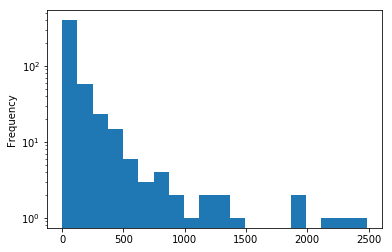

In [52]:
merged_routes.Name.value_counts().plot(kind='hist', log=True, bins=20)

In [53]:
merged_routes.Name.value_counts().describe()

count     522.000000
mean      127.394636
std       277.346000
min         1.000000
25%        14.000000
50%        34.000000
75%       111.000000
max      2484.000000
Name: Name, dtype: float64

What are the airlines with the most airports:

In [54]:
airport_count = merged_routes.groupby('Name').apply(
    lambda x: x.SourceAirport.drop_duplicates().count()).sort_values(ascending=False)
airport_count.head(10)

Name
American Airlines           429
United Airlines             426
Air France                  378
KLM Royal Dutch Airlines    360
US Airways                  348
Delta Air Lines             347
Alitalia                    269
Turkish Airlines            258
Lufthansa                   243
China Eastern Airlines      222
dtype: int64

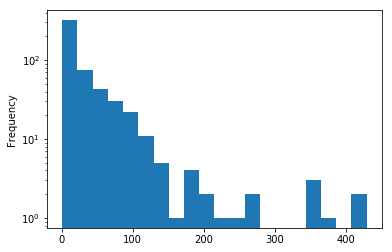

In [55]:
airport_count.plot(kind='hist', log=True, bins=20)

In [56]:
airport_count.describe()

count    522.000000
mean      35.954023
std       54.773603
min        1.000000
25%        8.000000
50%       16.000000
75%       41.000000
max      429.000000
dtype: float64

In [57]:
reasonably_big_airlines = merged_routes.Name.value_counts()[merged_routes.Name.value_counts() > 130].index

In [58]:
merged_routes = merged_routes[merged_routes.Name.isin(reasonably_big_airlines)]

We look at a total of 118 airlines:

In [59]:
len(merged_routes.Name.unique())

118

### Meta-Data analysis

Propotion of international to national flights

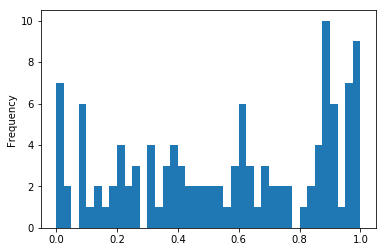

In [60]:
merged_routes.groupby('Name').International.mean().plot(kind='hist', bins=40)

mean distance of flights:

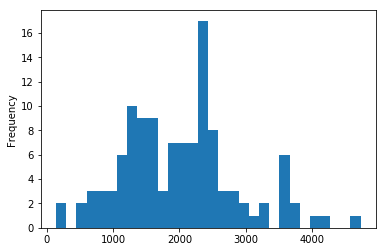

In [61]:
merged_routes.groupby('Name').Distance.mean().plot(kind='hist', bins=30)

Max distance of flights:

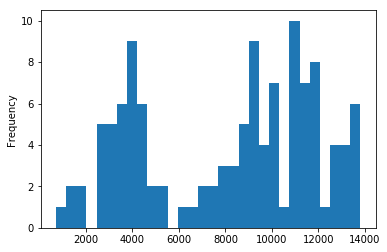

In [62]:
merged_routes.groupby('Name').Distance.max().plot(kind='hist', bins=30)

shortest distance of flight:

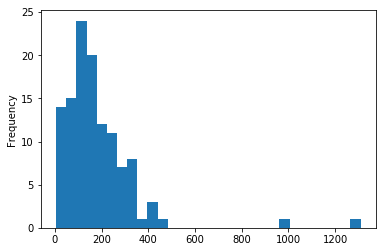

In [63]:
merged_routes.groupby('Name').Distance.min().plot(kind='hist', bins=30)

Proportion of codeshare flights:

In [64]:
merged_routes['Codeshare'] = merged_routes.Codeshare.map(lambda x: 1 if x == 'Y' else 0)

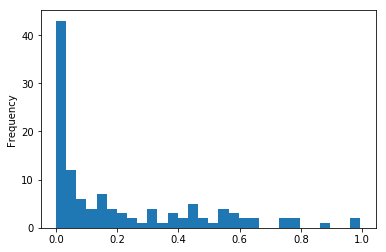

In [65]:
merged_routes.groupby('Name').Codeshare.mean().plot(kind='hist', bins=30)

## Create graph of all airlines:

Create graph with edge having airline associated to

In [66]:
biggest = merged_routes.AirlineNbr.value_counts().head(10).index

In [67]:
edge_attributes = ['Country', 'Name', 'AirlineNbr', 'Distance', 'International']

In [68]:
Airline_Graph = nx.from_pandas_edgelist(merged_routes, 
                                        source='SourceAirport', 
                                        target='DestinationAirport', 
                                        edge_attr=['Country', 'Name', 'AirlineNbr', 'Distance', 'International'])

In [69]:
color_edges = list(nx.get_edge_attributes(Airline_Graph, 'AirlineNbr').values())

In [70]:
nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')

In [71]:
Airport_to_city = airports.set_index('IATA').City.to_dict()
Airport_to_name = airports.set_index('IATA').Name.to_dict()
e_centrality = nx.eigenvector_centrality(Airline_Graph)
centrality = np.array(list(e_centrality.values()))

Major Airports:

In [72]:
major_airports = {Airport_to_name[k] for  k, v in e_centrality.items() if v > np.quantile(centrality, 0.99) and k in Airport_to_city.keys()}

In [73]:
major_airports

{'Adolfo Suárez Madrid–Barajas Airport',
 'Amsterdam Airport Schiphol',
 'Atatürk International Airport',
 'Barcelona International Airport',
 'Brussels Airport',
 'Charles de Gaulle International Airport',
 "Chicago O'Hare International Airport",
 'Copenhagen Kastrup Airport',
 'Dubai International Airport',
 'Dublin Airport',
 'Düsseldorf Airport',
 'Frankfurt am Main Airport',
 'Hartsfield Jackson Atlanta International Airport',
 'John F Kennedy International Airport',
 'Leonardo da Vinci–Fiumicino Airport',
 'Lester B. Pearson International Airport',
 'London Gatwick Airport',
 'London Heathrow Airport',
 'Malpensa International Airport',
 'Manchester Airport',
 'Munich Airport',
 'Newark Liberty International Airport',
 'Vienna International Airport',
 'Zürich Airport'}

## Looking at individual networks:

We build a function to create the airline network:

In [74]:
def create_airline_network(airline):
    df = merged_routes[merged_routes['Name'] == airline]
    Airline_Graph = nx.from_pandas_edgelist(df, 
                                      source='SourceAirport', target='DestinationAirport', edge_attr=['Country'])
    nx.set_node_attributes(Airline_Graph, location_mapping, 'Location')
    return Airline_Graph

In [75]:
Ryanair = create_airline_network('Ryanair')

In [76]:
merged_routes.head()

,Name,ICAO,Country,SourceAirport,DestinationAirport,Codeshare,Stops,Equipment,AirlineNbr,International,Distance
76,American Airlines,AAL,United States,ABE,CLT,1,0,CR9 CR7 CRJ,2,0.0,773.147838
77,American Airlines,AAL,United States,ABE,PHL,0,0,DH3,2,0.0,88.283143
78,American Airlines,AAL,United States,ABI,DFW,1,0,ERD ER4 CRJ,2,0.0,253.808916
79,American Airlines,AAL,United States,ABQ,DFW,0,0,M83 M80,2,0.0,915.506940
80,American Airlines,AAL,United States,ABQ,LAX,1,0,CR7 CRJ,2,0.0,1089.899312


In [77]:
def draw_airline_network(Airline_Graph, airline):
    plt.figure(figsize=(6, 6))
    centrality = nx.betweenness_centrality(Airline_Graph)
    size = np.array(list(centrality.values()))*600
    nx.draw_spring(Airline_Graph, node_size=size, width=0.1)
    plt.title(airline)
    plt.show()
    
def get_spectrum_figures(Airline_Graph):
    e, U = np.linalg.eigh(nx.normalized_laplacian_matrix(Airline_Graph).todense())
    plt.plot(e)
    plt.show()
    plt.plot(nx.laplacian_spectrum(Airline_Graph))
    plt.show()
    plt.boxplot(nx.degree_centrality(Airline_Graph).values())
    plt.show()

Example of some low cost airlines:

In [78]:
##todo put somewhere else

Low_cost = ['Southwest Airlines', 'Ryanair','easyJet', 'WestJet']

/anaconda3/envs/Biblio/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


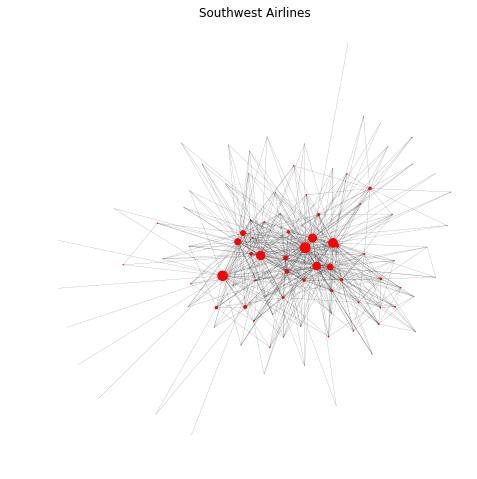

In [79]:
for cheap in Low_cost[:1]:
    Cheap = create_airline_network(cheap)
    draw_airline_network(Cheap, cheap)

## Preliminary analysis of network graphs

We know that the graph of all airlines is scalefree, but is the graph formed by individual airlines scalefree? 

In [98]:
def get_scalefree_network_stats(airline):
    Airline_Graph = create_airline_network(airline)
    
    
    components = nx.number_connected_components(Airline_Graph)
    component_ratio = 0
    density = nx.density(Airline_Graph)
    
    if components > 1 :
        c = sorted(nx.connected_components(Airline_Graph), key = len, reverse=True)
        Airline_Graph = Airline_Graph.subgraph(c[0])

    degrees = pd.Series(list((dict(nx.degree(Airline_Graph)).values())))
    
    density = nx.density(Airline_Graph)
    diameter = nx.diameter(Airline_Graph)
    pathlength = nx.average_shortest_path_length(Airline_Graph)

    return np.array([ degrees.mean(), degrees.std(), density])

In [104]:
airlines = merged_routes.Name.drop_duplicates()
stats = np.array(airlines.map(get_scalefree_network_stats).tolist())

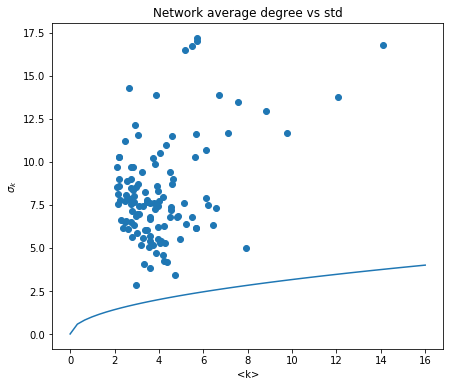

In [127]:
plt.figure(figsize=(7, 6))
plt.scatter(stats[:, 0], stats[:, 1])
plt.plot(np.linspace(0, 16), np.sqrt(np.linspace(0, 16)))
plt.xlabel('<k>')
plt.ylabel('$\sigma_k$')
plt.title('Network average degree vs std')
plt.show()

## Adding in external information: for relected airlines - case study

In [ ]:
Delays_data = pd.read_csv('delays_Data.csv')

In [ ]:
def convert_mixed_fractions(x):
    if '%' in x:
        return float(x[:-1])/100
    else:
        return float(x)

In [ ]:
Delays_data['On-time (A14)'] = Delays_data['On-time (A14)'].map(convert_mixed_fractions)
Airline_list = pd.read_csv('airlines_Data.csv')

# Network Structure

Clustering the networks based on stats:

Our first model only uses the laplacian the quantify the structure of the graph:

In [ ]:
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.community import greedy_modularity_communities

In [ ]:
def get_network_stats(airline):
    Airline_Graph = create_airline_network(airline)
    
    
    components = nx.number_connected_components(Airline_Graph)
    component_ratio = 0
    density = nx.density(Airline_Graph)
    
    if components > 1 :
        print(airline,'  ' ,components)
        
        c = sorted(nx.connected_components(Airline_Graph), key = len, reverse=True)
        component_ratio = len([i for t in c[1:] for i in t])/ len(c[0])
        Airline_Graph = Airline_Graph.subgraph(c[0])

    #connectivity pattern of airline
    hist = nx.degree_histogram(Airline_Graph)
    total = sum(hist)
    per_large_degree = sum(hist[5:])/total
    deadend = hist[1]/total
    
    #network pattern
    algebraic_connectivity = nx.algebraic_connectivity(Airline_Graph)
    spectrum = nx.normalized_laplacian_matrix(Airline_Graph).todense()
    eig, _ = np.linalg.eigh(spectrum)
    eig = np.array(sorted(eig))
    

    return np.array([#diameter, degree_assortativity, 
                     
                     #algebraic_connectivity, 
                     eig[1], 
                     eig[-1], 
                     pd.Series(eig.round(decimals=4)).value_counts()[1]/pd.Series(eig.round(decimals=4)).value_counts().sum(),
                     deadend, per_large_degree 
                     #upper_betweenness, median_betweenness, lower_betweenness
                    ])

Collecting the data:

In [ ]:
Stats = []
airlines = merged_routes.Name.unique()
for name in airlines:
    stat = get_network_stats(name)
    if type(stat) != None:
        Stats.append(stat)

Put everything into a matrix, do PCA for dimensionality reduction & cluster:

In [ ]:
network_stats = np.array(Stats)

#scale features so that each feature has same distribution
x = StandardScaler().fit_transform(network_stats)

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x[:, [0, 2]])
print(pca.explained_variance_ratio_) 

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
_ = cluster.fit_predict(principalComponents)  

In [ ]:
plt.scatter(x[:, 0], x[:,2], c=cluster.labels_, cmap=plt.cm.tab20)  
plt.show()
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=cluster.labels_, cmap=plt.cm.tab20)  

In [ ]:
plt.figure(figsize=(20, 20))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= cluster.labels_, cmap=plt.cm.tab20)  
for i, name in enumerate(airlines):
    plt.annotate(name, xy = (principalComponents[i, 0], principalComponents[i, 1]), 
             xytext = (0, 0), textcoords = 'offset points')

We identify nordic airlines from this graph:

In [ ]:
mask = (principalComponents[:, 1] > 2)
Components = principalComponents[mask]

In [ ]:
for nordic in airlines[mask]:
    Nordic = create_airline_network(nordic)
    draw_airline_network(Nordic, nordic)

Cheap airlines are all located in a corner of the cluster:

In [ ]:
mask = (principalComponents[:, 0] > 1.2) & (principalComponents[:, 1] < 1)
Components = principalComponents[mask]

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(Components[:,0], Components[:,1], cmap=plt.cm.tab20)  

for i, name in enumerate(airlines[mask]):
    plt.annotate(name, xy = (Components[i, 0], Components[i, 1]), 
             xytext = (0, 0), textcoords = 'offset points')

In [ ]:
for cheap in airlines[mask]:
    Cheap = create_airline_network(cheap)
    draw_airline_network(Cheap, cheap)

This is not the case with expensive airlines, while some of them are clustered together, lots of large, less pretigous ailines can also be found in these locations:

In [ ]:
mask = (principalComponents[:, 0] < -1.2) & (principalComponents[:, 1] < 1)
Components = principalComponents[mask]

In [ ]:
for expensive in airlines[mask]:
    Cheap = create_airline_network(expensive)
    draw_airline_network(Cheap, expensive)

But from the graphs of these airlines we can clearly recognize a strong pattern of large vs prestious airlines: prestigous airlines have a much more starlike structure. Hence, a better method would need to cluster starlike graphs closer together

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x[:, [0, 2, 3, 4]])
print(pca.explained_variance_ratio_) 

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
_ = cluster.fit_predict(principalComponents)  

plt.figure(figsize=(20, 20))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= cluster.labels_, cmap=plt.cm.tab20)  
for i, name in enumerate(airlines):
    plt.annotate(name, xy = (principalComponents[i, 0], principalComponents[i, 1]), 
             xytext = (0, 0), textcoords = 'offset points')

Now we see that the best airlines are all clustered together, and the cheapest airlines tend to be clustered together!

Now, what is the underlying confounding factor that could lead to such a distribution?

**Is the clustering due to international vs local flights?**

International airlines are much more likely to be world renowed, while cheap airlines may only provide inertcontinetal or even just naional travel. Here we check whether there is an indication of this in the graphs:

In [ ]:
d = airports.set_index('IATA').Country.to_dict()

In [ ]:
country_json= pd.read_json('country-by-continent.json').set_index('country').continent.to_dict()

In [ ]:
merged_routes['Intercontinental'] = merged_routes.apply(
    lambda x: country_json[d[x.SourceAirport]] != country_json[d[x.DestinationAirport]] , axis=1)

In [ ]:
color_international = merged_routes.groupby('Name').apply(lambda x: np.log(x.Intercontinental.sum())).tolist()

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= color_international, cmap=plt.cm.PuBu )  
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= merged_routes.groupby('Name').apply(lambda x: np.log(x.International.sum())).tolist(), cmap=plt.cm.PuBu )  
plt.colorbar()

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c= merged_routes.groupby('Name').apply(
    lambda x: x.Distance.sum()).tolist(), cmap=plt.cm.PuBu )  
plt.colorbar()

**Analyzing if there is corrleation between countries and structure:**

In [ ]:
most_common = merged_routes[~merged_routes.Name.duplicated()].Country.value_counts().head(3).index
most_common

In [ ]:
countries = list(most_common) + list(merged_routes.Country.unique())
airline_to_countryid = merged_routes.set_index('Name').Country.to_dict()
country_coloring = [countries.index(airline_to_countryid[i]
                                   ) if airline_to_countryid[i] in most_common else -1 for i in merged_routes.Name.unique() ]

In [ ]:
to_keep = [i for i, name in enumerate(airlines) if airline_to_countryid[name] in most_common]

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(principalComponents[:,0], 
            principalComponents[:,1], 
            c= np.array(country_coloring), 
            cmap=plt.cm.Set1_r)  
for i in to_keep:
    plt.annotate(airlines[i], xy = (principalComponents[i, 0], principalComponents[i, 1]), 
             xytext = (0, 0), textcoords = 'offset points')

One large cluster of american airways:

but we have some dispersion, and then a cheap airline cluster

In [ ]:
American_Airlines = ['Us Airways', 'Delta Airlines', 'American Airlines', 'United Airlines']

Total of 4 clusters for chinese airlines

In [ ]:
Chinese_Airlines = ['Air China', 'China Eastern Airlines', 'China Southern Airlines', 'Hainan Airlines']

1 clear cluster for United Arab Emirates:

In [ ]:
Emirate_Airlines = ['Fly Dubai', 'Emirates', 'Etihad Airways']

In [ ]:
Extreme_networks = ['Era Alaska', 'TUIfly', 'Emirates']

In [ ]:
for name in Extreme_networks:
    Airline_Graph = create_airline_network(name)
    draw_airline_network(Airline_Graph, name)

**Analyzing inference from eignevalues to Safety and Delays**

In [ ]:
scatter_data = pd.DataFrame(principalComponents)

scatter_data['name'] = airlines
scatter_data['labels'] = cluster.labels_
scatter_data['country'] = scatter_data.name.map(airline_to_countryid)

scatter_data['ontime'] = scatter_data.name.map(Delays_data.set_index('On-time')['On-time (A14)'].to_dict())
scatter_data['delay'] = scatter_data.name.map(Delays_data.set_index('On-time')['Avg. Delay'].to_dict())
scatter_data['safety'] = scatter_data.name.map(Airline_list.set_index('name').safety_score.to_dict())

scatter = scatter_data[scatter_data.delay.notna()].copy()

scatter['safety'] = scatter.safety.astype(float)

Only result I can see so far:
there is a delay line that goes from bottom left to top right:

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(scatter[0], 
            scatter[1], 
            c= scatter['delay'], 
            cmap=plt.cm.Spectral_r)  

for i in scatter.index:
    plt.annotate(scatter['name'][i], xy = (scatter[0][i], scatter[1][i]), 
             xytext = (0, 0), textcoords = 'offset points')
plt.colorbar()

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = np.array(Stats)[list(scatter.index)]

X = StandardScaler().fit_transform(X)

regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X[:,[0]+list(range(2,5))], scatter['delay'])

#resudual sum of squares
regr.score(X[:, [0]+list(range(2,5))], scatter['delay'])

In [ ]:
# Train the model using the training sets
regr.fit(X[:, 1:], scatter['delay'])

#resudual sum of squares
regr.score(X[:, 1:], scatter['delay'])

In [ ]:
scatter['pred'] = regr.predict(X[:, 1:])

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(scatter[0], 
            scatter[1], 
            c= scatter['pred'], 
            cmap=plt.cm.Spectral_r)  

for i in scatter.index:
    plt.annotate(scatter['name'][i], xy = (scatter[0][i], scatter[1][i]), 
             xytext = (0, 0), textcoords = 'offset points')
plt.colorbar()

In [ ]:
plt.bar(range(len(regr.coef_)), regr.coef_,)
[regr.coef_]

Adding robustness as a predictor:

In [ ]:
def get_network_stats_robustness(airline):
    Airline_Graph = create_airline_network(airline)
    
    
    components = nx.number_connected_components(Airline_Graph)
    component_ratio = 0
    density = nx.density(Airline_Graph)
    
    if components > 1 :
        print(airline,'  ' ,components)
        
        c = sorted(nx.connected_components(Airline_Graph), key = len, reverse=True)
        component_ratio = len([i for t in c[1:] for i in t])/ len(c[0])
        Airline_Graph = Airline_Graph.subgraph(c[0])

    #connectivity pattern of airline
    diameter = nx.diameter(Airline_Graph)
    degree_assortativity = nx.degree_assortativity_coefficient(Airline_Graph)
    
    #network pattern
    algebraic_connectivity = nx.algebraic_connectivity(Airline_Graph)
    
    
    #robustness of network
    nb = nx.betweenness_centrality(Airline_Graph, normalized=True)
    betweenness = np.array(list(nb.values()))
    upper_betweenness = np.quantile(betweenness, 0.75)
    median_betweenness = np.quantile(betweenness, 0.5)
    lower_betweenness = np.quantile(betweenness, 0.27)
    
    
    eb = nx.edge_betweenness_centrality(Airline_Graph, normalized=True)
    betweenness = np.array(list(eb.values()))
    e_upper_betweenness = np.quantile(betweenness, 0.75)
    e_median_betweenness = np.quantile(betweenness, 0.5)
    e_lower_betweenness = np.quantile(betweenness, 0.27)
    
    node_connectivity = nx.node_connectivity(Airline_Graph)
    
    return np.array([#diameter, degree_assortativity, 
                     #node_connectivity,
                     upper_betweenness, median_betweenness, 
                     e_upper_betweenness, e_median_betweenness,
                    ])

In [ ]:
Stats_between = []
airlines = scatter.name.unique()
for name in airlines:
    stat = get_network_stats_robustness(name)
    if type(stat) != None:
        Stats_between.append(stat)
network_stats_between = np.array(Stats_between)
x_between = StandardScaler().fit_transform(network_stats_between)

In [ ]:
x.shape

In [ ]:
scatter_extended = pd.concat([pd.DataFrame(x_between), X], ignore_index=True, axis=1)

In [ ]:
X_ = scatter_extended.iloc[:, :4]
X_ = StandardScaler().fit_transform(X_)

regr = linear_model.LinearRegression()
regr.fit(X_, scatter['delay'])
#resudual sum of squares
regr.score(X_, scatter['delay'])

In [ ]:
X_ = scatter_extended.iloc[:, :7]
X_ = StandardScaler().fit_transform(X_)

regr = linear_model.LinearRegression()
regr.fit(X_, scatter['delay'])
#resudual sum of squares
regr.score(X_, scatter['delay'])

In [ ]:
plt.bar(range(len(regr.coef_)), regr.coef_,)
[regr.coef_]

Plot based on all these values:

In [ ]:
Stats_between = []
airlines = merged_routes.Name.unique()
for name in airlines:
    stat = get_network_stats_robustness(name)
    if type(stat) != None:
        Stats_between.append(stat)
network_stats_between = np.array(Stats_between)
x_between = StandardScaler().fit_transform(network_stats_between)

In [ ]:
x_ = np.concatenate([x_between , x[:, [1,2]]], axis=1)

In [ ]:
pca = PCA(n_components=2)


In [ ]:
country_coloring = [scatter["pred"][ind]
 if i in scatter.name.tolist() else 0 for ind, i in enumerate(merged_routes.Name.unique() )]

In [ ]:
country_coloring = regr.predict(x_)

In [ ]:
principalComponents = pca.fit_transform(x_)

slope = pca.transform(np.array([regr.coef_]))


cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
_ = cluster.fit_predict(principalComponents)  

plt.figure(figsize=(30, 30))
plt.scatter(principalComponents[:,0], 
            principalComponents[:,1], 
            c= np.array(country_coloring), 
            cmap=plt.cm.Spectral_r, s=100)  
plt.colorbar()
for i, name in enumerate(airlines):
    plt.annotate(name, xy = (principalComponents[i, 0], principalComponents[i, 1]), 
             xytext = (0, 0), textcoords = 'offset points')
plt.show()

**Getting information summarized for individual networks:**

In [ ]:
def airlines_network_analysis(airline):
    
    Airline_Graph = create_airline_network(airline)
    
    #Highlights hubs   
    print("10% biggest airports of ", airline)
    print()
    deg = np.array(list(Airline_Graph.degree))
    deg_value = deg[:,1]
    deg_value = deg_value.astype(np.float)
    perc = np.percentile(deg_value, q=90)
    biggest_hubs = np.array(np.where(deg_value > perc))

    for i in np.nditer(biggest_hubs):
        print(airports[airports.IATA == deg[i,0]].Name.to_string(index=False), "has degree : ", deg[i,1])
    
    
    #Diameter,robustness
    print("Anlysis")
    print("Number of edges : ", Airline_Graph.number_of_edges())
    print("Number of nodes", Airline_Graph.number_of_nodes(), "nodes")
    print("Diameter : ", nx.diameter(Airline_Graph))
    print("Average distance:", merged_routes.groupby('Name').get_group(airline).Distance.mean())
    print("International Ratio: ",merged_routes.groupby('Name').get_group(airline).International.sum() / (Airline_Graph.size()*2))
    print("Node connectivity", nx.node_connectivity(Airline_Graph))
    
    eb = nx.edge_betweenness_centrality(Airline_Graph)
    key, value = max(eb.items(), key = lambda p: p[1])
    print("Max edge betwenness: ",value , "from ", Airport_to_city.get(key[0]), "to", Airport_to_city.get(key[1]))
    key, value = min(eb.items(), key = lambda p: p[1])
    print("Min edge betwenness: ",value, "from", Airport_to_city.get(key[0]), "to", Airport_to_city.get(key[1]))
                                                            
    nb = nx.betweenness_centrality(Airline_Graph)
    key, value = max(nb.items(), key= lambda p:p[1])
    print("Max node betwenness: ", value, "airport", Airport_to_city.get(key))
    key, value = min(nb.items(), key= lambda p:p[1])
    print("Min node betwenness: ", value, "airport", Airport_to_city.get(key))
    print("Algbraic connectivity: ", nx.algebraic_connectivity(Airline_Graph))
    
    #Plot network
    plt.figure(figsize=[7,9])
    plt.subplot(211)
    plt.title('Degree Distribution')
    plt.hist(deg_value, bins=50)
    
    plt.subplot(212)
    plt.title('Distances distribution')
    merged_routes.groupby('Name').get_group(airline).Distance.hist(bins=30)
    
    draw_airline_network(Airline_Graph, airline)
    

In [ ]:
airlines_network_analysis('Ryanair')

In [ ]:
airlines_network_analysis('American Airlines')

In [ ]:
#High cooperation probability based on common bottlenecks 
def find_helper(airline):
    Airline_Graph = create_airline_network(airline)
    #bottlenecks
    eb = nx.edge_betweenness_centrality(Airline_Graph)
    #Decreasing sorting 
    eb_sorted = sorted(eb.items(), key = lambda p: 1-p[1])
    #find helper for the bottleneck
    for i in range(5):
        print('Betweenness value ' , eb_sorted[i][1])
        print('Bottleneck from ', Airport_to_city.get(eb_sorted[i][0][0]), 'to', Airport_to_city.get(eb_sorted[i][0][1]))
        
        helper_routes = merged_routes[(merged_routes.SourceAirport == eb_sorted[i][0][0]) & (merged_routes.DestinationAirport == eb_sorted[i][0][1])]
        if (helper_routes.shape[0] > 1):
            print('Best helpers : ')
            print((helper_routes[helper_routes.Name != airline].Name.to_string(index=False)))
            print()
        else:
            print(airline, ' is the unique airline \n\n')
            

find_helper('American Airlines')


## Competition Analysis

In [ ]:
merged_routes['SourceCountry'] = merged_routes.apply(lambda x: 
                Airport_to_country[x.SourceAirport], axis=1)
merged_routes['DestinationCountry'] = merged_routes.apply(lambda x: 
                Airport_to_country[x.DestinationAirport], axis=1)
merged_routes.head(5)

In [ ]:
def overlaps(route_a, route_b):
    source_dist = distance(distance_mapping[route_a['SourceAirport']],
                           distance_mapping[route_b['SourceAirport']]).km
    dest_dist = distance(distance_mapping[route_a['DestinationAirport']],
                         distance_mapping[route_b['DestinationAirport']]).km
    return source_dist <= 100 and dest_dist <= 100

"""
Computed the overlap (competition) score between two airlines.
It takes not only nodes into consideration but also the edges.
So, if Airline A goes from Bucharest to Zurich and Airline B
from Geneva to Zurich, based on this fact only, they are not
competitors.
"""
def compute_overlap_score(airline_x, airline_y):
    routes_x = merged_routes[merged_routes.Name == airline_x]
    routes_y = merged_routes[merged_routes.Name == airline_y]
    
    score = 0
    for i, row_x in routes_x.iterrows():
        does_overlap = False
        joined_routes = routes_y[(routes_y.SourceCountry == row_x['SourceCountry']) &
                                 (routes_y.DestinationCountry == row_x['DestinationCountry'])]
        for j, row_y in joined_routes.iterrows():
            if overlaps(row_x, row_y):
                does_overlap = True
        if does_overlap:
            score += 1
    return score / len(routes_x)

compute_overlap_score("Ryanair", "Wizz Air")

In [ ]:
"""
Computed the overlap (competition) score between given airlines.
It takes not only nodes into consideration but also the edges.
So, if Airline A goes from Bucharest to Zurich and Airline B
from Geneva to Zurich, based on this fact only, they are not
competitors.
"""
def compute_overlap_scores(airline_list):
    scores = []
    for airline_a in airline_list:
        for airline_b in airline_list:
            scores.append([airline_a, airline_b, compute_overlap_score(airline_a, airline_b)])
    return pd.DataFrame(scores, columns = ['AirlineA', 'AirlineB', 'Score'])

In [ ]:
overlap_scores = compute_overlap_scores(["Ryanair", "Wizz Air"])
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Low_cost)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Best_Airlines)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Large_Airlines)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(Chinese)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")

In [ ]:
overlap_scores = compute_overlap_scores(airlines.Name)
sns.heatmap(overlap_scores.pivot("AirlineA", "AirlineB", "Score"), cmap="YlGnBu")